# Plot regions used in the study and table of available dataset/models per parameter

In [18]:
from trends_functions import *
import pyaerocom as pya
from warnings import filterwarnings
import pandas as pd
import matplotlib.patheffects as PathEffects
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing
filterwarnings('ignore')
pya.change_verbosity('critical', pya.const.logger)
pya.change_verbosity('critical', pya.const.print_log)

In [12]:
# import seaborn style
sns.set()
sns.set_context("paper")
# sns.set_style("whitegrid")
sns.color_palette("muted")
# since each figure will be a subfigure, increase font_size
fscale = 1.0
sns.set(font_scale=fscale)

### start with regions map

In [13]:
regions = get_regions()

In [14]:
parameters = ['od550aer', 'concpm10', 'concso4', 'scatc550dryaer', 'absc550aer']

In [15]:
#read observations
OBS = {}

for i, var in enumerate(parameters):
    # computation parameters
    params = get_params()
    params['kind'] = 'obs'
    fill_params(params, var)

    params['var'] = var
    obs_source = params['source']
    reader = pya.io.ReadUngridded(obs_source)
    obs_data = reader.read(vars_to_retrieve=var)
    
    #compte the trend just to have filtering (300 points, ...)
    _, OBS[var], _ = process_trend(
        obs_data, params,
        plot=False, show_plot=False, save_plot=False, write_json=False
    )

no flags
no flags EUROPE station:  ZvenigoroddsEi_GCWD
no flags ASIA station:  Zhongshan_UnivityDhASIA station:  DRAGON_Fukue_2 ASIA station:  DRAGON_Pandan_Resrv ASIA station:  Mobile_Kanpur_SE
no flags NAMERICA station:  Yumaowknife_AuroraC NAMERICA station:  Calipso_Hillsboro NAMERICA station:  Calipso_Zion NAMERICA station:  DRAGON_Channel_View NAMERICA station:  DRAGON_SHADY NAMERICA station:  Pickle_Lake
no flags SAMERICA station:  Veracruz_MAX_MEXFOP
no flags NAFRICA station:  Zinder_DMNporttutea
region:  SAFRICA station:  Walvis_Bay_airport
Less than 7 points in selected period
no flags
no flags AUSTRALIA station:  Tinga_Tinganand_QLD
region:  ASIA station:  Petalling JayaI Gentésertrch Observatorytpso_Hillsboro_E WORLD station:  Chen-Kung_Univ WORLD station:  Resolute_Bay
Less than 7 points in selected period
No station found in , SAFRICArraablo de los MontesCyprus Atmospheric Observatory
No station found in , AUSTRALIA
no flags WORLD station:  Zosenibodenntainstional Park-Lin

In [16]:
thead = ['Region', 'Lat [Min-Max]', 'Lon [Min-Max]']
tbody = []
for region in regions:
    pyreg = pya.Region(region)
    tbody.append([pyreg.name, pyreg['lat_range'], pyreg['lon_range']])
df = pd.DataFrame(tbody,columns=thead)

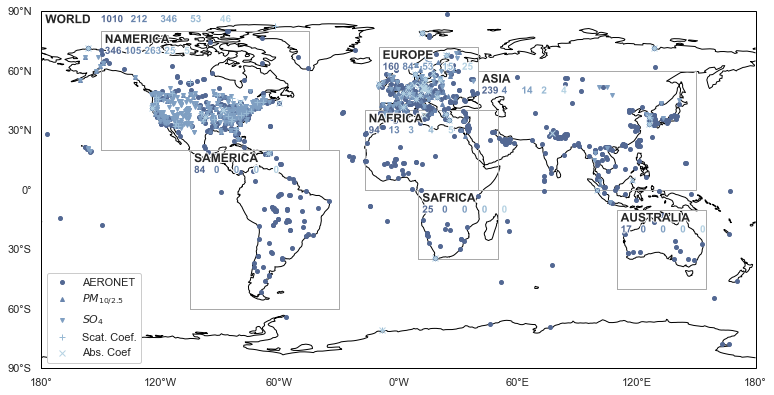

In [20]:
nl, nc = 1, 1
fs = 0.8
plt.figure(figsize=(16*fs,9*fs))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

#plot the regions
for region in regions:
    pyreg = pya.Region(region)
    
    reglons = pyreg['lon_range']
    reglats = pyreg['lat_range']
    
    #get rectangle coordinates
    lons = [reglons[0], reglons[0], reglons[1], reglons[1]]
    lats = [reglats[0], reglats[1], reglats[1], reglats[0]]
    ring = LinearRing(list(zip(lons, lats)))
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='darkgray')
    x0, y0 = reglons[0]+2, reglats[1]-2
    txt = ax.text(x0, y0, pyreg['_name'], ha='left', va='top', fontweight='bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

#plot the observations available
palette = sns.cubehelix_palette(len(parameters), start=0, rot=-.15, dark=.4, light=.8, reverse=True)
#palette = sns.color_palette("pastel")
#parameters = ['od550aer', 'concpm10', 'concso4', 'scatc550dryaer', 'absc550aer']
networks = ['AERONET', '$PM_{10/2.5}$', '$SO_{4}$', 'Scat. Coef.', 'Abs. Coef']
colors = [palette[i] for i, var in enumerate(parameters)]
markers = ['o','^', 'v', '+', 'x']
sizes = [4, 4, 4, 6, 6]
for i, var in enumerate(parameters):
    lons = [station ['lon'] for station in OBS[var]['WORLD']['stations']]
    lats = [station ['lat'] for station in OBS[var]['WORLD']['stations']]
    ax.plot(lons, lats, marker=markers[i], lw=0, ms=sizes[i], color=colors[i], alpha=1, transform=ccrs.PlateCarree(), label=networks[i] )
    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    #add nmax
    for region in regions:
        pyreg = pya.Region(region)
        reglons = pyreg['lon_range']
        reglats = pyreg['lat_range']
        y0 = reglats[1]-2
        if region=='WORLD':
            x0 = reglons[0]+30
            dx = 15
            dy = 0
        else:
            x0 = reglons[0]+2
            dx=10
            dy = 6
        if region in OBS[var]:
            nmax = len(OBS[var][region]['stations'])
        else:
            nmax = 0
        txt = ax.text(x0+i*dx, y0-dy, nmax, ha='left', va='top', fontweight='bold', fontsize=10, color=colors[i])
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
        
plt.legend(fancybox=True,framealpha=1, shadow=False, facecolor='white')
#setbackground color
ax.set_facecolor('#F1F1F1')
plt.savefig('figs/maps/av_obs.png', dpi=300, bbox_inches='tight')

### for each parameter, list of available models

In [3]:
parameters = ['ang4487aer', 'od550aer', 'od550gt1aer',
        'od550lt1aer', 'concpm10', 'concpm25', 'concso4', 'scatc550dryaer', 'absc550aer']

In [4]:
all_mods = get_all_mods()

thead = ['Parameter', 'Observation Network', 'Models grp 0', 'Models grp 1']
tbody = []
for var in parameters:
    params = get_params()
    fill_params(params, var)
    mods0 = []
    mods1 = []
    mods = params['models']
    
    for mod in mods:
        str_mod = mod.split('_')[0]
        #str_mod = str_mod.split('-')[0]
        if mod==params['ref_model']:
            str_mod = str_mod+'$^{*}$'
        
        if mod in all_mods and all_mods[mod]['group'] == 'group0':
            mods0.append(str_mod)
        else:
            mods1.append(str_mod)
    
    #convert list into a string
    mods0 = '; '.join(mods0)
    mods1 = '; '.join(mods1)
    
    if mods0=='':
        mods0 = '-'
    if mods1=='':
        mods1 = '-'
    
    
    #source
    source = params['source']
    source = source.split('.')[0]
    
    tbody.append([params['ylabel'], source, mods0, mods1])

df = pd.DataFrame(tbody, columns=thead)

In [5]:
with pd.option_context("max_colwidth", 1000):
    latable = df.to_latex(index=False, longtable=False, escape=False)
    #replace rule with hline for ACP
    latable = latable.replace('toprule','tophline')
    latable = latable.replace('midrule','middlehline')
    latable = latable.replace('bottomrule','bottomhline')
    print(latable)

\begin{tabular}{llll}
\tophline
   Parameter &  Observation Network & Models grp 0 &                                                                                                                                          Models grp 1 \\
\middlehline
          AE &     AeronetSunV3Lev2 &            - &                                                       ECMWF; OsloCTM3v1.01-met2010; CAM5-ATRAS; GFDL-AM4-amip$^{*}$; GEOS-i33p2; ECHAM6.3-HAM2.3-fSST \\
         AOD &     AeronetSunV3Lev2 &            - &  ECMWF; OsloCTM3v1.01-met2010; NorESM2-LM; CAM5-ATRAS; GFDL-AM4-amip$^{*}$; CanESM5; CESM2; IPSL-CM6A-LR; GEOS-i33p2; ECHAM6.3-HAM2.3-fSST; BCC-CUACE \\
     AOD>1µm &     AeronetSDAV3Lev2 &            - &                                                        ECMWF; OsloCTM3v1.01-met2010; BCC-CUACE; CAM5-ATRAS; GFDL-AM4-amip$^{*}$; ECHAM6.3-HAM2.3-fSST \\
     AOD<1µm &     AeronetSDAV3Lev2 &            - &                                                                               

### Print table Param - Obs - Models

In [6]:
all_mods = get_all_mods()

thead = ['Parameter', 'Observation Network', 'Models']
tbody = []
for var in parameters:
    params = get_params()
    fill_params(params, var)
    str_mods = []
    mods = params['models']
    
    for mod in mods:
        str_mod = get_all_mods()[mod]['name']
        #str_mod = str_mod.split('-')[0]
        #if mod in all_mods and all_mods[mod]['group'] == 'CAMS_Rean':
        #    str_mod += '$^{0}$'
        #elif mod in all_mods and all_mods[mod]['group'] == 'AP3':
        #    str_mod += '$^{1}$'
        #elif mod in all_mods and all_mods[mod]['group'] == 'CMIP6':
        #    str_mod += '$^{2}$'
        if mod==params['ref_model']:
            str_mod += '$^{*}$'
        str_mods.append(str_mod)
    
    #convert list into a string
    str_mods = '; '.join(str_mods)
    
    if str_mods=='':
        str_mods = '-'
    
    #source
    source = params['source']
    source = source.split('.')[0]
    
    tbody.append([params['ylabel'], source, str_mods])

df = pd.DataFrame(tbody, columns=thead)

In [7]:
with pd.option_context("max_colwidth", 1000):
    latable = df.to_latex(index=False, longtable=False, escape=False)
    #replace rule with hline for ACP
    latable = latable.replace('toprule','tophline')
    latable = latable.replace('midrule','middlehline')
    latable = latable.replace('bottomrule','bottomhline')
    print(latable)

\begin{tabular}{lll}
\tophline
   Parameter &  Observation Network &                                                                                                            Models \\
\middlehline
          AE &     AeronetSunV3Lev2 &                                                 ECMWF-Rean; OsloCTM3; CAM5-ATRAS; GFDL-AM4$^{*}$; GEOS; ECHAM-HAM \\
         AOD &     AeronetSunV3Lev2 &  ECMWF-Rean; OsloCTM3; NorESM2; CAM5-ATRAS; GFDL-AM4$^{*}$; CanESM5; CESM2; IPSL-CM6A; GEOS; ECHAM-HAM; BCC-CUACE \\
     AOD>1µm &     AeronetSDAV3Lev2 &                                            ECMWF-Rean; OsloCTM3; BCC-CUACE; CAM5-ATRAS; GFDL-AM4$^{*}$; ECHAM-HAM \\
     AOD<1µm &     AeronetSDAV3Lev2 &                                                                                   GFDL-AM4$^{*}$; GEOS; ECHAM-HAM \\
        PM10 &               EBASMC &                                                                                 ECMWF-Rean$^{*}$; GEOS; ECHAM-HAM \\
       PM2.5 &            

### Print table Model - Emissions - Meterorology - Resolution

In [8]:
models = list(all_mods.keys())

thead = ['Model', 'Group', 'Emission', 'Meteorology', 'Resolution']
tbody = []

for model in models:
    model_name = get_all_mods()[model]['name']
    tbody.append([model_name,all_mods[model]['group'],'?','?', '?'])
    
df = pd.DataFrame(tbody, columns=thead)

In [9]:
with pd.option_context("max_colwidth", 1000):
    latable = df.to_latex(index=False, longtable=False, escape=False)
    #replace rule with hline for ACP
    latable = latable.replace('toprule','tophline')
    latable = latable.replace('midrule','middlehline')
    latable = latable.replace('bottomrule','bottomhline')
    print(latable)

\begin{tabular}{lllll}
\tophline
      Model &      Group & Emission & Meteorology & Resolution \\
\middlehline
 ECMWF-Rean &  CAMS-Rean &        ? &           ? &          ? \\
       GEOS &        AP3 &        ? &           ? &          ? \\
   OsloCTM3 &        AP3 &        ? &           ? &          ? \\
    NorESM2 &        AP3 &        ? &           ? &          ? \\
 CAM5-ATRAS &        AP3 &        ? &           ? &          ? \\
   GFDL-AM4 &        AP3 &        ? &           ? &          ? \\
  ECHAM-HAM &        AP3 &        ? &           ? &          ? \\
  BCC-CUACE &        AP3 &        ? &           ? &          ? \\
    CanESM5 &      CMIP6 &        ? &           ? &          ? \\
      CESM2 &      CMIP6 &        ? &           ? &          ? \\
  IPSL-CM6A &      CMIP6 &        ? &           ? &          ? \\
\bottomhline
\end{tabular}

